In [95]:
import numpy as np
import pandas as pd

from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    make_scorer,
)
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    ParameterGrid,
    ParameterSampler,
    RandomizedSearchCV,
)
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor


In [96]:
df = pd.read_json("hh_ru_vacancies.jsonlines", lines=True)
df['salary_mean'] = (df['salary'].apply(lambda x: x.get('from') if isinstance(x, dict) else 0).astype(float) + df['salary'].apply(lambda x: x.get('to') if isinstance(x, dict) else 0).astype(float)) / 2
df.head()

,company_id,vacancy_id,company_nm,vacancy_nm,experience,schedule,work_hours,publication_dt,salary,location,...,similar_ids,current_view_count,scraped_timestamp,metro_line_nm,metro_station_nm,location_lat,location_lon,profession_id,accept_incomplete_resumes,salary_mean
0,11875449.0,127076681,ПрессБук,Электромонтажник ( Челябинск ),between1And3,OTHER,HOURS_10,2025-11-09T17:07:02.523+03:00,"{'from': 165000, 'to': 180000, 'currencyCode':...",Челябинск,...,"[{'company_id': 11875449, 'vacancy_id': 127158...",0,1762736415,None,None,55.159900,61.402550,143,True,172500.0
1,4716984.0,124551351,X5 Digital,Водитель-Курьер в Пятёрочку,noExperience,FLEXIBLE,HOURS_4,2025-10-20T14:05:51.292+03:00,"{'to': 184000, 'currencyCode': 'RUR', 'gross':...","Суслонгер, Первомайская, 1",...,[],0,1762736416,None,None,56.316320,48.256362,58,True,NaN
2,10628995.0,125668881,Финагент,Выездной специалист Альфа-Банка - автокурьер н...,noExperience,SIX_ON_ONE_OFF,HOURS_8,2025-10-23T16:40:30.810+03:00,"{'from': 70000, 'currencyCode': 'RUR', 'gross'...",Юрино,...,"[{'company_id': 80, 'vacancy_id': 126008701}, ...",0,1762736415,None,None,NaN,NaN,58,True,NaN
3,2784143.0,126477226,Птицефабрика Акашевская,Ветеринарный лаборант,noExperience,FIVE_ON_TWO_OFF,HOURS_8,2025-10-13T15:18:57.147+03:00,"{'from': 36200, 'to': 36200, 'currencyCode': '...",посёлок Юбилейный,...,"[{'company_id': 2784143, 'vacancy_id': 1270459...",0,1762736416,None,None,56.748775,48.215968,168,False,36200.0
4,2594000.0,126513468,Племзавод Семёновский,Агроном (Сернурский район),between1And3,SIX_ON_ONE_OFF,HOURS_7,2025-10-14T12:17:59.102+03:00,"{'from': 80000, 'to': 90000, 'currencyCode': '...",деревня Верхний Кугенер,...,[],0,1762736416,None,None,56.891932,49.202695,7,True,85000.0


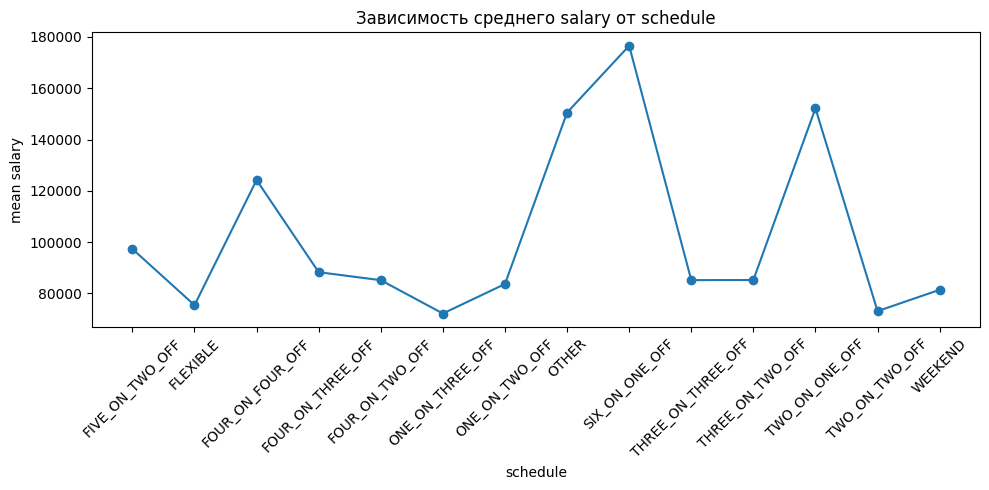

In [97]:
# строим график зависимости среднего зарплаты от schedule
mean_by_schedule = (
    df.groupby('schedule')['salary_mean']
      .mean()
      .reset_index()
)

plt.figure(figsize=(10, 5))
plt.plot(mean_by_schedule['schedule'], mean_by_schedule['salary_mean'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('schedule')
plt.ylabel('mean salary')
plt.title('Зависимость среднего salary от schedule')
plt.tight_layout()
plt.show()

In [55]:
# # строим график зависимости среднего зарплаты от experience
# mean_by_schedule = (
#     df.groupby('experience')['salary_mean']
#       .mean()
#       .reset_index()
# )

# plt.figure(figsize=(10, 5))
# plt.plot(mean_by_schedule['experience'], mean_by_schedule['salary_mean'], marker='o')
# plt.xticks(rotation=45)
# plt.xlabel('experience')
# plt.ylabel('mean salary')
# plt.title('Зависимость среднего salary от experience')
# plt.tight_layout()
# plt.show()

In [98]:
# выбор нужных данных для модели
new_df = df[["location", 'experience', 'schedule']].copy()

for c in ["location", 'experience', 'schedule']:
    new_df[c] = new_df[c].fillna('unknown').astype(str)

new_df['work_hours'] = (
    df['work_hours']
    .replace('OTHER', 'HOURS_8')
    .astype(str)
    .str.extract(r'_(\d+)')[0]
    .astype(float)
)

new_df["profession_id"] = df["profession_id"].astype(str)
new_df['salary_from'] = df['salary'].apply(lambda x: x.get('from') if isinstance(x, dict) else 0).astype(float)
new_df['salary_to'] = df['salary'].apply(lambda x: x.get('to') if isinstance(x, dict) else 0).astype(float)
new_df['skills_text'] = df['key_skills'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '').astype(str)

new_df.head(10)

,location,experience,schedule,work_hours,profession_id,salary_from,salary_to,skills_text
0,Челябинск,between1And3,OTHER,10.0,143,165000.0,180000.0,
1,"Суслонгер, Первомайская, 1",noExperience,FLEXIBLE,4.0,58,NaN,184000.0,
2,Юрино,noExperience,SIX_ON_ONE_OFF,8.0,58,70000.0,NaN,"Пользователь ПК, Грамотная речь, работа с доку..."
3,посёлок Юбилейный,noExperience,FIVE_ON_TWO_OFF,8.0,168,36200.0,36200.0,
4,деревня Верхний Кугенер,between1And3,SIX_ON_ONE_OFF,7.0,7,80000.0,90000.0,"Пользователь ПК, Работа в команде, Водительско..."
5,Лыткарино,between1And3,OTHER,10.0,143,168000.0,NaN,
6,"Суслонгер, Железнодорожная, 13",noExperience,TWO_ON_TWO_OFF,12.0,40,53000.0,53000.0,
7,Ступино,between1And3,SIX_ON_ONE_OFF,12.0,128,232128.0,NaN,"Точность и внимательность к деталям, Чтение че..."
8,"посёлок городского типа Сернур, Советская улиц...",noExperience,TWO_ON_TWO_OFF,8.0,70,39000.0,NaN,
9,Советский (Республика Марий Эл),noExperience,THREE_ON_THREE_OFF,10.0,52,115000.0,140000.0,


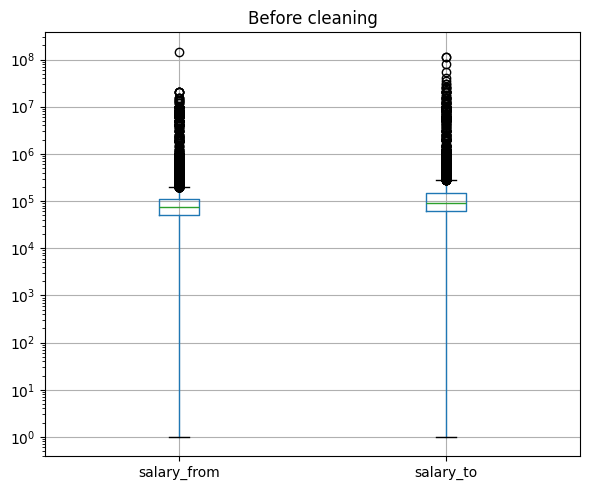

In [99]:
df_plot = new_df[['salary_from', 'salary_to']].copy()
df_plot = df_plot.replace([np.inf, -np.inf], np.nan).dropna()

plt.figure(figsize=(6, 5))
new_df[['salary_from', 'salary_to']].boxplot()
plt.yscale('log')
plt.title('Before cleaning')
plt.tight_layout()
plt.show()

In [ ]:
# уборка пропусков выбросов и аномалии
X = new_df.drop(columns=['salary_from', 'salary_to'])
y = new_df[['salary_from', 'salary_to']]


# пропуски
mask = y['salary_from'].notna() & y['salary_to'].notna()
X_clean = X[mask].reset_index(drop=True)
y_clean = y[mask].reset_index(drop=True)

# явные ошибки
mask = (y_clean['salary_from'] > 0) & (y_clean['salary_to'] > 0) & \
       (y_clean['salary_from'] <= y_clean['salary_to'])
X_clean = X_clean[mask].reset_index(drop=True)
y_clean = y_clean[mask].reset_index(drop=True)

# нижний порог
mask = (y_clean['salary_from'] > 5000) & (y_clean['salary_to'] > 5000)
X_min = X_clean[mask].reset_index(drop=True)
y_min = y_clean[mask].reset_index(drop=True)

# выбросы
q1_low, q1_high = y_min['salary_from'].quantile([0.01, 0.99])
q2_low, q2_high = y_min['salary_to'].quantile([0.01, 0.99])

mask_out = (y_min['salary_from'].between(q1_low, q1_high)) & \
           (y_min['salary_to'].between(q2_low, q2_high))

X = X_min[mask_out].reset_index(drop=True)
y = y_min[mask_out].reset_index(drop=True)

# логирование
y_log = np.log1p(y)


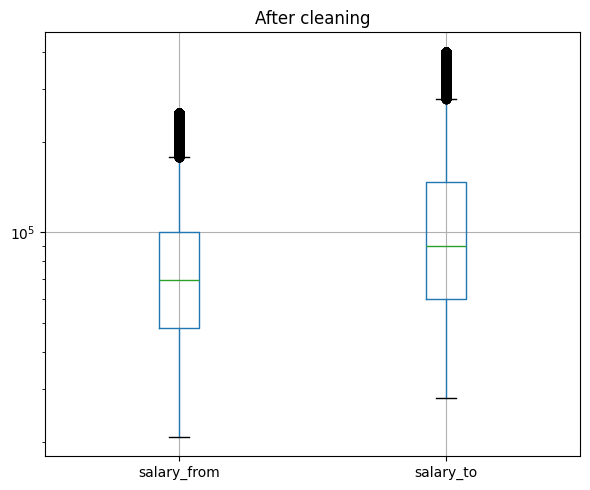

In [101]:
plt.figure(figsize=(6, 5))
y[['salary_from', 'salary_to']].boxplot()
plt.yscale('log')
plt.title('After cleaning')
plt.tight_layout()
plt.show()

In [102]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

X_train2, X_val, y_train2, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

cat_features_index = [
    X_train2.columns.get_loc(c)
    for c in ['schedule', 'experience', 'location', 'profession_id']
]

text_features_index = [
    X_train2.columns.get_loc(c)
    for c in ['skills_text']
]

In [82]:
# # подбор гиперпарметров для модели catboost и создание модели

# param_distributions = {
#     'depth': [6, 8],
#     'learning_rate': [0.03, 0.05],
#     'l2_leaf_reg': [3, 5, 7],
#     'bagging_temperature': [0.0, 0.5, 1.0],
#     'rsm': [0.7, 0.9]
# }

# best_score = np.inf
# best_params = None
# best_model = None
# sampler = ParameterSampler(param_distributions, n_iter=20, random_state=42)
# for params in sampler:
#     print("Пробую параметры:", params)

#     model = CatBoostRegressor(
#         iterations=2000,
#         loss_function='MultiRMSE',
#         random_state=42,
#         verbose=False,
#         **params
#     )

#     model.fit(
#         X_train2,
#         y_train2,
#         cat_features=cat_features_index,
#         text_features=text_features_index,
#         eval_set=(X_val, y_val),
#         use_best_model=True,
#         early_stopping_rounds=100
#     )

#     y_val_pred_log = model.predict(X_val)


#     y_val_true = np.expm1(y_val.values)
#     y_val_pred = np.expm1(y_val_pred_log)

#     mae = mean_absolute_error(y_val_true, y_val_pred)

#     print(f"MAE на валидации: {mae:.2f}")

#     if mae < best_score: 
#         best_score = mae
#         best_params = params
#         best_model = model

# print("\nЛучшие параметры:")
# print(best_params)
# print("Лучший MAE:", best_score)
# model_cat = best_model


In [103]:
model_cat = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.05,
    depth=8,
    loss_function='MultiRMSE',
    random_state=42,
    verbose=False,
    rsm=0.7,
    l2_leaf_reg=5,
    bagging_temperature=0.0
)

model_cat.fit(
    X_train2,
    y_train2,
    cat_features=cat_features_index,
    eval_set=(X_val, y_val),
    use_best_model=True,
    early_stopping_rounds=100,
    text_features=text_features_index
)



In [104]:
y_pred_log = model_cat.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test1 = np.expm1(y_test)

mae = mean_absolute_error(y_test1, y_pred)

rmse = np.sqrt(mean_squared_error(y_test1, y_pred))

mae_from = mean_absolute_error(y_test1.iloc[:,0], y_pred[:,0])
mae_to = mean_absolute_error(y_test1.iloc[:,1], y_pred[:,1])
# метрики
print("MAE (общий):", mae)
print("RMSE (общий):", rmse)
print("MAE salary_from:", mae_from)
print("MAE salary_to:", mae_to)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_from = mape(y_test1.iloc[:, 0].values, y_pred[:, 0])
mape_to = mape(y_test1.iloc[:, 1].values, y_pred[:, 1])

print("MAPE salary_from (%):", mape_from)
print("MAPE salary_to (%):", mape_to)


# Проверка генерализационного разрыва, переобчуения
print("Лучшее количество итераций:", model_cat.tree_count_)
print("валидация:", model_cat.get_best_score()["validation"]["MultiRMSE"])
print("обучение:", model_cat.get_best_score()["learn"]["MultiRMSE"])


MAE (общий): 20697.219198006806
RMSE (общий): 32381.682157194933
MAE salary_from: 17140.34007988634
MAE salary_to: 24254.09831612727
MAPE salary_from (%): 23.69541326582227
MAPE salary_to (%): 24.470417433296422
Лучшее количество итераций: 2000
валидация: 0.4348830282177155
обучение: 0.42975514987115143


In [105]:
model_filename = 'model_catboost_new_final.cbm'

model_cat.save_model(model_filename)

print(f"Модель успешно сохранена в файл: {model_filename}")

Модель успешно сохранена в файл: model_catboost_new_final.cbm


In [73]:
cat_cols = ["vacancy_nm", "location", 'experience', 'schedule', 'skills_text']

num_cols = ["work_hours"]

preprocess = ColumnTransformer(
    transformers=[
        ('cat',
         OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         cat_cols),
        ('num', 'passthrough', num_cols)
    ]
)

xgb_base = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.05,
    max_depth=8,
    objective='reg:squarederror',
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

model_xgb = Pipeline([
    ('prep', preprocess),
    ('reg', MultiOutputRegressor(xgb_base))
])

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_distributions = {
    'reg__estimator__learning_rate': np.linspace(0.01, 0.15, 7),
    'reg__estimator__max_depth': [4, 6, 8, 10],
    'reg__estimator__subsample': [0.6, 0.8, 1.0],
    'reg__estimator__colsample_bytree': [0.6, 0.8, 1.0],
    'reg__estimator__reg_lambda': [0.1, 1.0, 5.0],
}

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=mae_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train2, y_train2)

print("Лучшие параметры:")
print(random_search.best_params_)
print("Лучший MAE:", -random_search.best_score_)
model_xgb = random_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/timbudygin/PycharmProjects/Новая папка/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Лучшие параметры:
{'reg__estimator__subsample': 1.0, 'reg__estimator__reg_lambda': 5.0, 'reg__estimator__max_depth': 10, 'reg__estimator__learning_rate': np.float64(0.03333333333333333), 'reg__estimator__colsample_bytree': 0.8}
Лучший MAE: 0.33527783552805585


In [ ]:

y_train_pred = model_xgb.predict(X_train2)
y_val_pred = model_xgb.predict(X_val)

# метрики 
mae_from = mean_absolute_error(y_val.iloc[:, 0], y_val_pred[:, 0])
mae_to = mean_absolute_error(y_val.iloc[:, 1], y_val_pred[:, 1])

# общие метрики
mae = mean_absolute_error(y_val, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print("MAE (общий):", mae)
print("RMSE (общий):", rmse)
print("MAE salary_from:", mae_from)
print("MAE salary_to:", mae_to)

# проверка переобучения
mae_train = mean_absolute_error(y_train2, y_train_pred)
mae_val = mae

print("MAE train:", mae_train)
print("MAE val:", mae_val)
print("Разница:", mae_val - mae_train)

MAE (общий): 0.32973116636276245
RMSE (общий): 0.44969533434969683
MAE salary_from: 0.31259378627664536
MAE salary_to: 0.3468686311445596
MAE train: 0.14307937026023865
MAE val: 0.32973116636276245
Разница: 0.1866517961025238
